In [46]:
# load dataset
import re
import string
import codecs

f = codecs.open("socialmedia-disaster-tweets-DFE-cleaned2.csv", "r", encoding = 'utf-8', errors = 'ignore') 
raw_data = f.readlines()

In [47]:
# make a list of relevant / non-relevant tweet and labels
import numpy as np

labels_0 = []
tweets_0 = []
labels_1 = []
tweets_1 = []

for line in raw_data:
    line_split = line.split(",", 1)
    [l_labels, l_tweets] = line_split
    if l_labels == '0':
        labels_0.append(int(l_labels))
        tweets_0.append(l_tweets)
    elif l_labels == '1':
        labels_1.append(int(l_labels))
        tweets_1.append(l_tweets)
    
labels_0 = np.array(labels_0)
labels_1 = np.array(labels_1)

In [48]:
# function to clean text
# (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words
def makeWordList(corpus_text):
    
    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    text = text.lower().split()           # -- (4)         

    li = []
    for token in text:
        li.append(token)
    
    return " ".join(li)

In [49]:
# create a cleaned tweet text list
cleaned_tweet_list_0 = []
cleaned_tweet_list_1 = []

for tweet in tweets_0:
    clean_tweet_text_0 = makeWordList(tweet)
    cleaned_tweet_list_0.append(clean_tweet_text_0)
    
for tweet in tweets_1:
    clean_tweet_text_1 = makeWordList(tweet)
    cleaned_tweet_list_1.append(clean_tweet_text_1)

In [50]:
# create one string of tweets text
all_corpus_0 = ''
for tweet in cleaned_tweet_list_0:
    all_corpus_0 += tweet
    
all_corpus_1 = ''
for tweet in cleaned_tweet_list_1:
    all_corpus_1 += tweet

In [51]:
# count the most frequent words and sort 
from collections import Counter
import spacy

nlp = spacy.load('en', disable=['ner', 'parser', 'tagger'])
nlp.max_length = 70000000
doc_0 = nlp(all_corpus_0)
doc_1 = nlp(all_corpus_1)

histogram_0 = Counter()
histogram_1 = Counter()

for token in doc_0:
    lemma = token.lemma_.lower()
    if not (nlp.vocab[lemma].is_stop or token.pos_ == 'PUNCT' or token.pos_ == 'SPACE'):
        histogram_0[lemma] += 1
    
from operator import itemgetter
sorted_lemma_count_pairs_0 = sorted(histogram_0.items(),
                                    reverse=True,
                                    key=itemgetter(1))

for token in doc_1:
    lemma = token.lemma_.lower()
    if not (nlp.vocab[lemma].is_stop or token.pos_ == 'PUNCT' or token.pos_ == 'SPACE'):
        histogram_1[lemma] += 1
    
from operator import itemgetter
sorted_lemma_count_pairs_1 = sorted(histogram_1.items(),
                                    reverse=True,
                                    key=itemgetter(1))

Text(0,0.5,'Raw count')

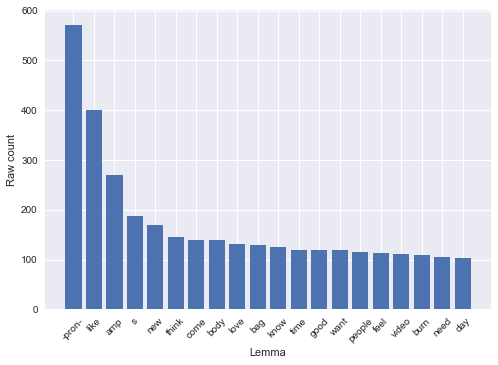

In [52]:
# plot the top 20 frequent words in non-relevant group
import matplotlib.pyplot as plt
plt.style.use('seaborn')  

num_top_lemmas_to_plot = 20
top_lemmas_0 = [lemma for lemma, count in sorted_lemma_count_pairs_0[:num_top_lemmas_to_plot]]
top_counts_0 = [count for lemma, count in sorted_lemma_count_pairs_0[:num_top_lemmas_to_plot]]
plt.bar(range(num_top_lemmas_to_plot), top_counts_0)
plt.xticks(range(num_top_lemmas_to_plot), top_lemmas_0, rotation=45)
plt.xlabel('Lemma')
plt.ylabel('Raw count')

Text(0,0.5,'Raw count')

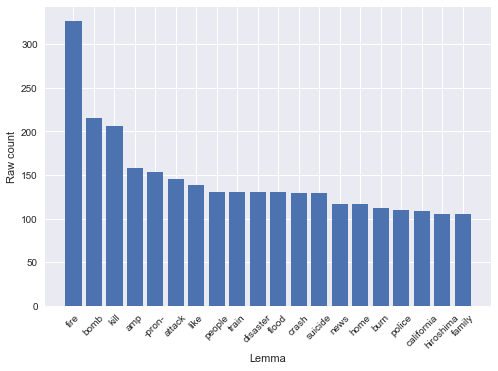

In [53]:
# plot the top 20 frequent words in relevant group

top_lemmas_1 = [lemma for lemma, count in sorted_lemma_count_pairs_1[:num_top_lemmas_to_plot]]
top_counts_1 = [count for lemma, count in sorted_lemma_count_pairs_1[:num_top_lemmas_to_plot]]
plt.bar(range(num_top_lemmas_to_plot), top_counts_1)
plt.xticks(range(num_top_lemmas_to_plot), top_lemmas_1, rotation=45)
plt.xlabel('Lemma')
plt.ylabel('Raw count')

In [54]:
# create a whole tweet list and label list
labels = np.hstack([labels_0, labels_1])
document_list = cleaned_tweet_list_0 + cleaned_tweet_list_1
document_list = np.array(document_list)

In [55]:
# make a test data for classification 
# Randomly select 100 tweet data from the document matrix and use it to test data
np.random.seed(0)

num_tweet = len(document_list)
num_tweet_test = 100
num_tweet_train = len(document_list) - num_tweet

id_all = np.random.choice(num_tweet, num_tweet, replace = False)
id_test = id_all[0:num_tweet_test]
id_train = id_all[num_tweet_test:num_tweet]

X_test = document_list[id_test]
X_train = document_list[id_train]
Y_test = labels[id_test]
Y_train = labels[id_train]

In [56]:
# create document matrix for train and test data 
# ignore words appear more than 50% tweets, less than 10 tweets 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words = 'english', min_df = 10, max_df = 0.6) 

X_train_d = vectorizer.fit_transform(X_train).toarray() 
X_test_d = CountVectorizer(vocabulary=vectorizer.vocabulary_).fit_transform(X_test).toarray()

In [57]:
# k-NN model
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
rng = np.random.RandomState(0)

num_folds = 5
k_fold = StratifiedKFold(num_folds, random_state=rng)
param_values = np.arange(1, 10, 1)

arg_max = -np.inf
best_k = None
for i in param_values:
    fold_scores = []
    print("k = " + str(i))
    for k, (train, val) in enumerate(k_fold.split(X_train_d, Y_train)):
        clf = KNeighborsClassifier(n_neighbors = i)
        clf.fit(X_train_d[train], Y_train[train])
        
        ypred = clf.predict(X_train_d[val])
        yval = Y_train[val]
        a = f1_score(yval, ypred, average='weighted')
        fold_scores.append(a)
        print("\t[fold {0}] k: {1:.5f}, accuracy: {2:.5f}".format(k, i, a))
        
    cross_val_score = np.mean(fold_scores)
    print("\tMean F1 score: " + str(cross_val_score))
    
    if cross_val_score > arg_max:
        arg_max = cross_val_score
        best_k = i
            
print('Best k:', best_k)

k = 1
	[fold 0] k: 1.00000, accuracy: 0.68814
	[fold 1] k: 1.00000, accuracy: 0.69567
	[fold 2] k: 1.00000, accuracy: 0.70246
	[fold 3] k: 1.00000, accuracy: 0.72435
	[fold 4] k: 1.00000, accuracy: 0.72395
	Mean F1 score: 0.7069156024354604
k = 2
	[fold 0] k: 2.00000, accuracy: 0.70382
	[fold 1] k: 2.00000, accuracy: 0.69047
	[fold 2] k: 2.00000, accuracy: 0.70544
	[fold 3] k: 2.00000, accuracy: 0.69754
	[fold 4] k: 2.00000, accuracy: 0.71513
	Mean F1 score: 0.7024819504876115
k = 3
	[fold 0] k: 3.00000, accuracy: 0.71361
	[fold 1] k: 3.00000, accuracy: 0.71975
	[fold 2] k: 3.00000, accuracy: 0.71644
	[fold 3] k: 3.00000, accuracy: 0.72345
	[fold 4] k: 3.00000, accuracy: 0.72008
	Mean F1 score: 0.7186661428938997
k = 4
	[fold 0] k: 4.00000, accuracy: 0.69122
	[fold 1] k: 4.00000, accuracy: 0.70367
	[fold 2] k: 4.00000, accuracy: 0.70620
	[fold 3] k: 4.00000, accuracy: 0.69464
	[fold 4] k: 4.00000, accuracy: 0.69704
	Mean F1 score: 0.6985552815173093
k = 5
	[fold 0] k: 5.00000, accuracy

In [58]:
%%time
# SVM model 
from sklearn import svm

num_folds = 5
k_fold = StratifiedKFold(num_folds, random_state=rng)
param_values = np.logspace(-4, 2, 3)

arg_max = -np.inf
best_C = None
for C in param_values:
    fold_scores = []
    print("C = " + str(C))
    for k, (train, val) in enumerate(k_fold.split(X_train_d, Y_train)):
        clf = svm.LinearSVC(C=C)
        clf.fit(X_train_d[train], Y_train[train])
        
        ypred = clf.predict(X_train_d[val])
        yval = Y_train[val]
        a = f1_score(yval, ypred, average='weighted')
        fold_scores.append(a)
        print("\t[fold {0}] C: {1:.5f}, accuracy: {2:.5f}".format(k, C, a))
        
    cross_val_score = np.mean(fold_scores)
    print("\tMean F1 score: " + str(cross_val_score))
    
    if cross_val_score > arg_max:
        arg_max = cross_val_score
        best_C = C
            
print('Best C:', best_C)

C = 0.0001
	[fold 0] C: 0.00010, accuracy: 0.42852
	[fold 1] C: 0.00010, accuracy: 0.43294
	[fold 2] C: 0.00010, accuracy: 0.43902
	[fold 3] C: 0.00010, accuracy: 0.44002
	[fold 4] C: 0.00010, accuracy: 0.43395
	Mean F1 score: 0.4348903449487847
C = 0.1
	[fold 0] C: 0.10000, accuracy: 0.78135
	[fold 1] C: 0.10000, accuracy: 0.79588
	[fold 2] C: 0.10000, accuracy: 0.79654
	[fold 3] C: 0.10000, accuracy: 0.79550
	[fold 4] C: 0.10000, accuracy: 0.79412
	Mean F1 score: 0.7926784076991614
C = 100.0
	[fold 0] C: 100.00000, accuracy: 0.75190
	[fold 1] C: 100.00000, accuracy: 0.76146
	[fold 2] C: 100.00000, accuracy: 0.76504
	[fold 3] C: 100.00000, accuracy: 0.77495
	[fold 4] C: 100.00000, accuracy: 0.76767
	Mean F1 score: 0.764204511635955
Best C: 0.1
Wall time: 5.68 s


In [60]:
# Random forest model
from sklearn.ensemble import RandomForestClassifier

num_folds = 5
k_fold = StratifiedKFold(num_folds, random_state=rng)
param_values = [(n_estimators, max_depth)
                for n_estimators in [50, 100, 150]
                for max_depth in [5, 10, 20, 100]]

arg_max = -np.inf
best_arg = None
for n_estimators, max_depth in param_values:
    fold_scores = []
    print("n_estimators = " + str(n_estimators)
          + ', max_depth = ' + str(max_depth))
    for k, (train, val) in enumerate(k_fold.split(X_train_d, Y_train)):
        clf = RandomForestClassifier(n_estimators=n_estimators,
                                     max_depth=max_depth,
                                     random_state=rng)
        clf.fit(X_train_d[train], Y_train[train])
        
        ypred = clf.predict(X_train_d[val])
        yval = Y_train[val]
        a = f1_score(yval, ypred, average='weighted')
        fold_scores.append(a)
        print("\t[fold {0}] accuracy: {1:.5f}".format(k, a))
        
    cross_val_score = np.mean(fold_scores)
    print("\tMean F1 score: " + str(cross_val_score))
    
    if cross_val_score > arg_max:
        arg_max = cross_val_score
        best_arg = (n_estimators, max_depth)

best_n_estimators, best_max_depth = best_arg
print('Best n_estimators:', best_n_estimators)
print('Best max_depth:', best_max_depth)

n_estimators = 50, max_depth = 5
	[fold 0] accuracy: 0.51166
	[fold 1] accuracy: 0.52715
	[fold 2] accuracy: 0.53175
	[fold 3] accuracy: 0.52011
	[fold 4] accuracy: 0.53399
	Mean F1 score: 0.5249309127248362
n_estimators = 50, max_depth = 10
	[fold 0] accuracy: 0.59649
	[fold 1] accuracy: 0.60768
	[fold 2] accuracy: 0.59223
	[fold 3] accuracy: 0.60549
	[fold 4] accuracy: 0.60357
	Mean F1 score: 0.6010915080919192
n_estimators = 50, max_depth = 20
	[fold 0] accuracy: 0.66700
	[fold 1] accuracy: 0.66154
	[fold 2] accuracy: 0.66363
	[fold 3] accuracy: 0.66603
	[fold 4] accuracy: 0.66551
	Mean F1 score: 0.6647415378172605
n_estimators = 50, max_depth = 100
	[fold 0] accuracy: 0.76594
	[fold 1] accuracy: 0.77095
	[fold 2] accuracy: 0.76594
	[fold 3] accuracy: 0.77558
	[fold 4] accuracy: 0.78606
	Mean F1 score: 0.772896437428793
n_estimators = 100, max_depth = 5
	[fold 0] accuracy: 0.52302
	[fold 1] accuracy: 0.54443
	[fold 2] accuracy: 0.52369
	[fold 3] accuracy: 0.51899
	[fold 4] accuracy:

In [61]:
# best k-NN
clf = KNeighborsClassifier(n_neighbors = best_k)
clf.fit(X_train_d, Y_train)
predicted_labels_knn = clf.predict_proba(X_test_d)[:,1]

# best svm 
clf = svm.SVC(C = best_C)
clf.fit(X_train_d, Y_train)
predicted_labels_svm = clf.decision_function(X_test_d)

# best rm 
rf = RandomForestClassifier(n_estimators = best_n_estimators,
                            max_depth = best_max_depth,
                            random_state = 0)
rf.fit(X_train_d, Y_train)
predicted_labels_rf = rf.predict_proba(X_test_d)[:,1] 

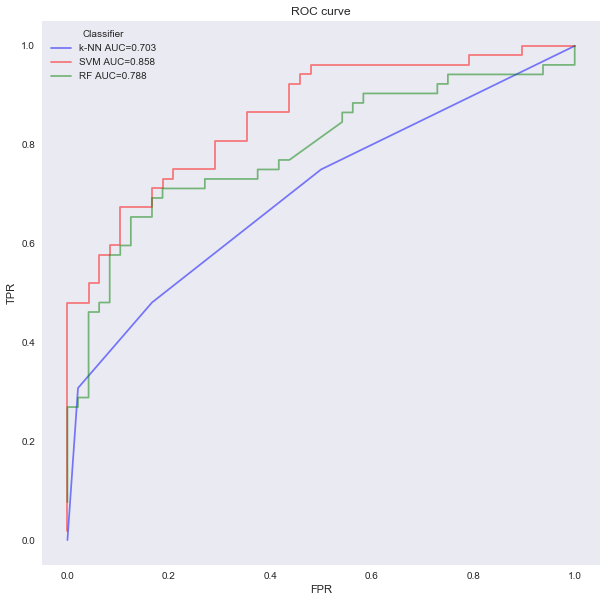

In [62]:
# plot ROC curve
from sklearn.metrics import roc_curve
plt.figure(figsize=(10,10))

fpr_knn, tpr_knn, thresholds_knn = roc_curve(Y_test, predicted_labels_knn, pos_label=1)
auc_knn = np.trapz(tpr_knn, fpr_knn)
plt.plot(fpr_knn, tpr_knn, linestyle = '-', alpha = 0.5, color = 'blue', label = 'k-NN AUC='+"{:.3f}".format(auc_knn))

fpr_svm, tpr_svm, thresholds_svm = roc_curve(Y_test, predicted_labels_svm, pos_label=1)
auc_svm = np.trapz(tpr_svm, fpr_svm)
plt.plot(fpr_svm, tpr_svm, linestyle = '-', alpha = 0.5, color = 'red', label = 'SVM AUC='+"{:.3f}".format(auc_svm))

fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, predicted_labels_rf, pos_label=1)
auc_rf = np.trapz(tpr_rf, fpr_rf)
plt.plot(fpr_rf, tpr_rf, linestyle = '-', alpha = 0.5, color = 'green', label = 'RF AUC='+"{:.3f}".format(auc_rf))

plt.title("ROC curve")
plt.legend(title = "Classifier", loc = "best")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.show() 

In [63]:
f.close()